# Netflix Data Analysis

This notebook executes six SQL queries on the `NETFLIX` database to analyze Netflix content and generates visualizations for each query. The database is hosted on SQL Server 2022 (`DESKTOP-UFR6MA7\SQLEXPRESS`) with tables `netflix_stg`, `netflix_genre`, `netflix_country`, and `netflix_directors`.

## Setup
- **Database**: `NETFLIX`
- **Connection**: Uses Windows Authentication with `ODBC Driver 17 for SQL Server`.
- **Libraries**: `pandas`, `sqlalchemy`, `pyodbc`, `matplotlib`, `seaborn`.
- **Visualizations**: Bar charts and count plots using Seaborn with the `seaborn-v0_8` style.

### Install Dependencies (if needed)
Run in a terminal:
```bash
pip install pandas sqlalchemy pyodbc matplotlib seaborn

In [7]:

# Import libraries
import sqlalchemy as sal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8')  # Use seaborn-v0_8 to avoid style error
sns.set_palette("muted")

# Database connection
DB_NAME = "NETFLIX"  # Replace with your database name if different
engine = sal.create_engine(f'mssql+pyodbc://DESKTOP-UFR6MA7\\SQLEXPRESS/{DB_NAME}?Trusted_Connection=Yes&driver=ODBC+Driver+17+for+SQL+Server')

# Function to execute query and handle errors
def run_query(query, query_name):
    try:
        df = pd.read_sql(query, engine)
        print(f"{query_name} Results:")
        print(df.head())
        print("\n")
        return df
    except Exception as e:
        print(f"Error in {query_name}: {e}")
        return pd.DataFrame()

## Query 1: Directors with Both Movies and TV Shows
Counts the number of movies and TV shows created by directors who have produced both types, ordered by movie count descending.

Query 1 Results:
            director  no_of_movies  no_of_tv_shows
0       Marcus Raboy            15               1
1  Quentin Tarantino             7               1
2        Ryan Polito             7               1
3      Michael Simon             5               1
4       Oliver Stone             4               1




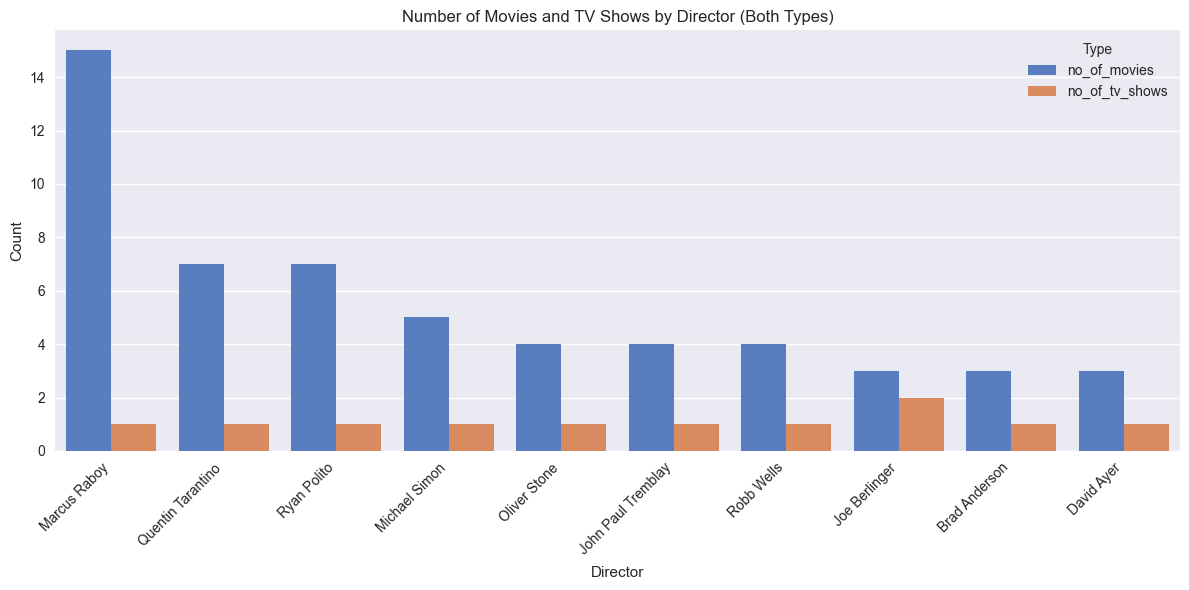

In [8]:
query1 = """
SELECT nd.director, 
       COUNT(DISTINCT CASE WHEN n.type='Movie' THEN n.show_id END) AS no_of_movies,
       COUNT(DISTINCT CASE WHEN n.type='TV Show' THEN n.show_id END) AS no_of_tv_shows
FROM netflix_stg n 
INNER JOIN netflix_directors nd ON n.show_id = nd.show_id
GROUP BY nd.director
HAVING COUNT(DISTINCT n.type) > 1
ORDER BY no_of_movies DESC, no_of_tv_shows DESC
"""
df1 = run_query(query1, "Query 1")

# Visualization: Grouped bar chart
if not df1.empty:
    df1_melted = df1.head(10).melt(id_vars='director', value_vars=['no_of_movies', 'no_of_tv_shows'], 
                                   var_name='type', value_name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df1_melted, x='director', y='count', hue='type')
    plt.title('Number of Movies and TV Shows by Director (Both Types)')
    plt.xlabel('Director')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Type')
    plt.tight_layout()
    plt.savefig('results/directors_movies_tvshows.png')
    plt.show()
    plt.close()

## Query 2: Top Countries by Comedy Movies
Identifies countries with the highest number of comedy movies, ordered by count descending.

Query 2 Results:
          country  no_of_movies
0   United States           615
1           India           328
2   United States            70
3           Egypt            63
4  United Kingdom            60




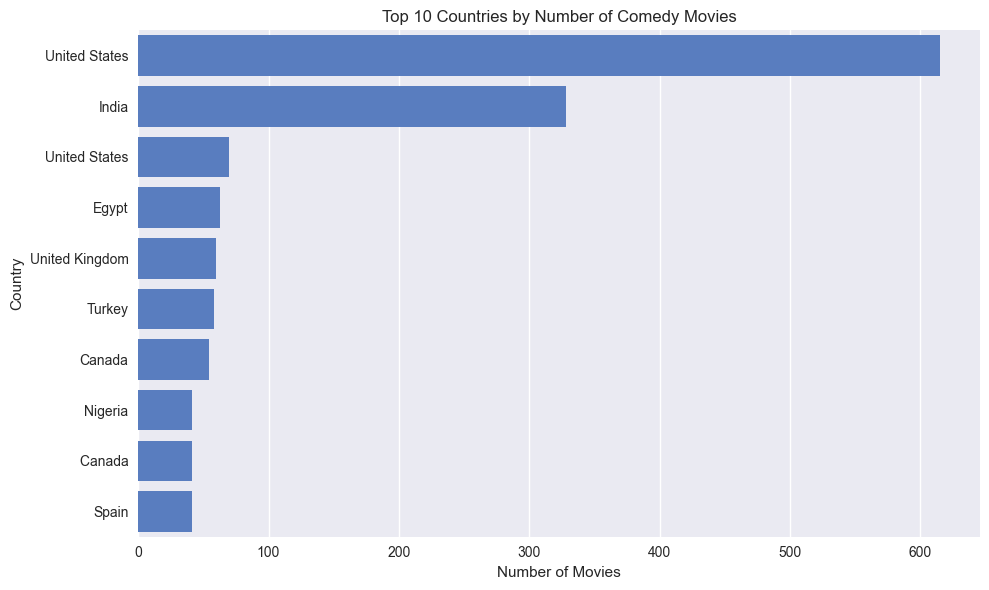

In [9]:
query2 = """
SELECT nc.country, COUNT(DISTINCT ng.show_id) AS no_of_movies
FROM netflix_genre ng
INNER JOIN netflix_country nc ON ng.show_id = nc.show_id
INNER JOIN netflix_stg n ON ng.show_id = n.show_id 
WHERE ng.genre = 'Comedies' AND n.type = 'Movie'
GROUP BY nc.country
ORDER BY no_of_movies DESC
"""
df2 = run_query(query2, "Query 2")

# Visualization: Bar chart for top 10 countries
if not df2.empty:
    df2_top10 = df2.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df2_top10, x='no_of_movies', y='country')
    plt.title('Top 10 Countries by Number of Comedy Movies')
    plt.xlabel('Number of Movies')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.savefig('results/comedy_movies_by_country.png')
    plt.show()
    plt.close()

## Query 3: Top Director by Movies per Year
Finds the director with the maximum number of movies released each year (based on `date_added`).

Query 3 Results:
   date_year              director  no_of_movies
0       2008  Sorin Dan Mihalcescu             1
1       2009             Joe Dante             1
2       2010            Jim Monaco             1
3       2011     Robert C. Ramirez             1
4       2012       Constance Marks             1




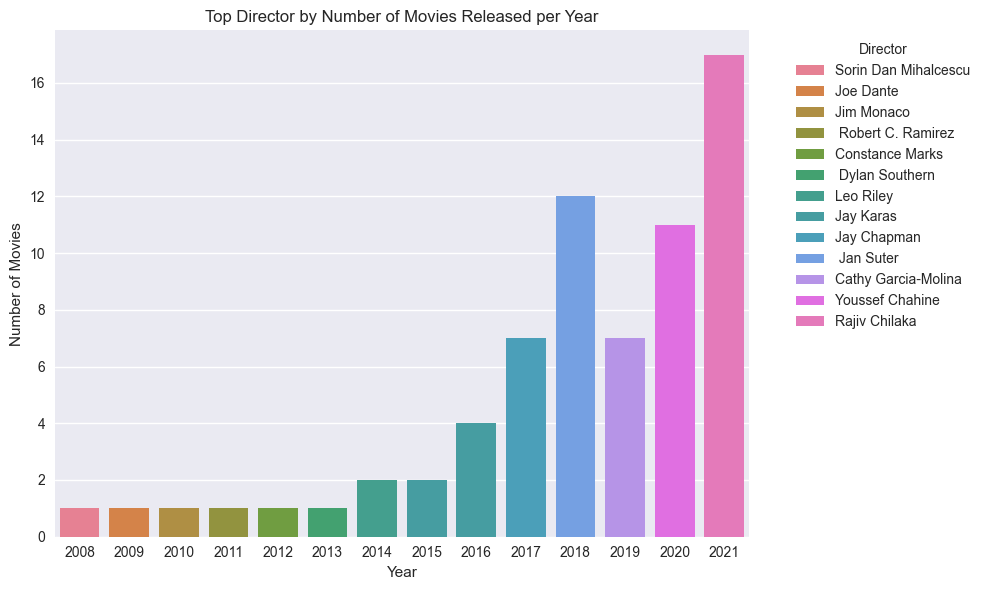

In [10]:
query3 = """
WITH cte AS (
    SELECT nd.director, YEAR(date_added) AS date_year, COUNT(DISTINCT n.show_id) AS no_of_movies
    FROM netflix_stg n
    INNER JOIN netflix_directors nd ON n.show_id = nd.show_id
    WHERE type = 'Movie'
    GROUP BY nd.director, YEAR(date_added)
),
cte2 AS (
    SELECT *, ROW_NUMBER() OVER(PARTITION BY date_year ORDER BY no_of_movies DESC, director) AS rn
    FROM cte
)
SELECT date_year, director, no_of_movies
FROM cte2 WHERE rn = 1
ORDER BY date_year
"""
df3 = run_query(query3, "Query 3")

# Visualization: Bar chart for top director per year
if not df3.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df3, x='date_year', y='no_of_movies', hue='director', dodge=False)
    plt.title('Top Director by Number of Movies Released per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.legend(title='Director', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('results/top_director_per_year.png')
    plt.show()
    plt.close()

## Query 4: Average Movie Duration by Genre
Calculates the average duration of movies for each genre, assuming `duration` is stored as a string (e.g., '120 min').

Query 4 Results:
                  genre  avg_duration
0        Classic Movies           118
1    Action & Adventure           113
2                Dramas           113
3       Romantic Movies           110
4  International Movies           110




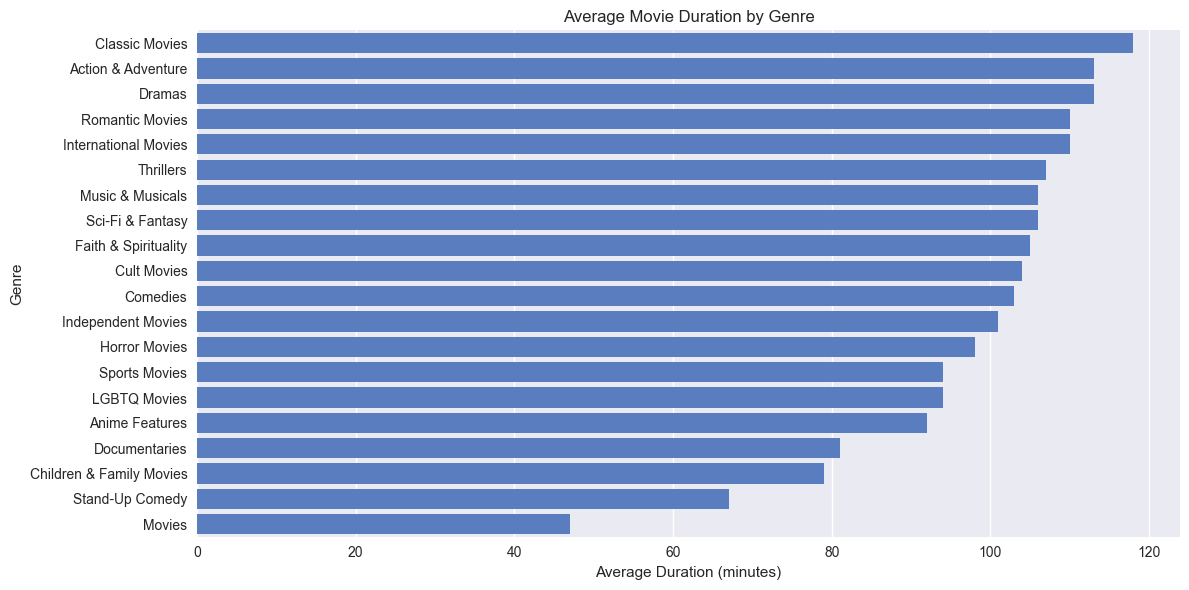

In [11]:
query4 = """
SELECT ng.genre, AVG(CAST(REPLACE(duration, ' min', '') AS INT)) AS avg_duration
FROM netflix_stg n
INNER JOIN netflix_genre ng ON n.show_id = ng.show_id
WHERE type = 'Movie'
GROUP BY ng.genre
ORDER BY avg_duration DESC
"""
df4 = run_query(query4, "Query 4")

# Visualization: Bar chart for average duration by genre
if not df4.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df4, x='avg_duration', y='genre')
    plt.title('Average Movie Duration by Genre')
    plt.xlabel('Average Duration (minutes)')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.savefig('results/avg_duration_by_genre.png')
    plt.show()
    plt.close()

## Query 5: Directors with Both Horror and Comedy Movies
Lists directors who have created both horror and comedy movies, with counts for each genre.

Query 5 Results:
         director  no_of_comedy  no_of_horror
0  Michael Tiddes             4             2
1     Kevin Smith             4             2
2             McG             4             2
3     Steve Brill             4             1
4       Poj Arnon             3             4




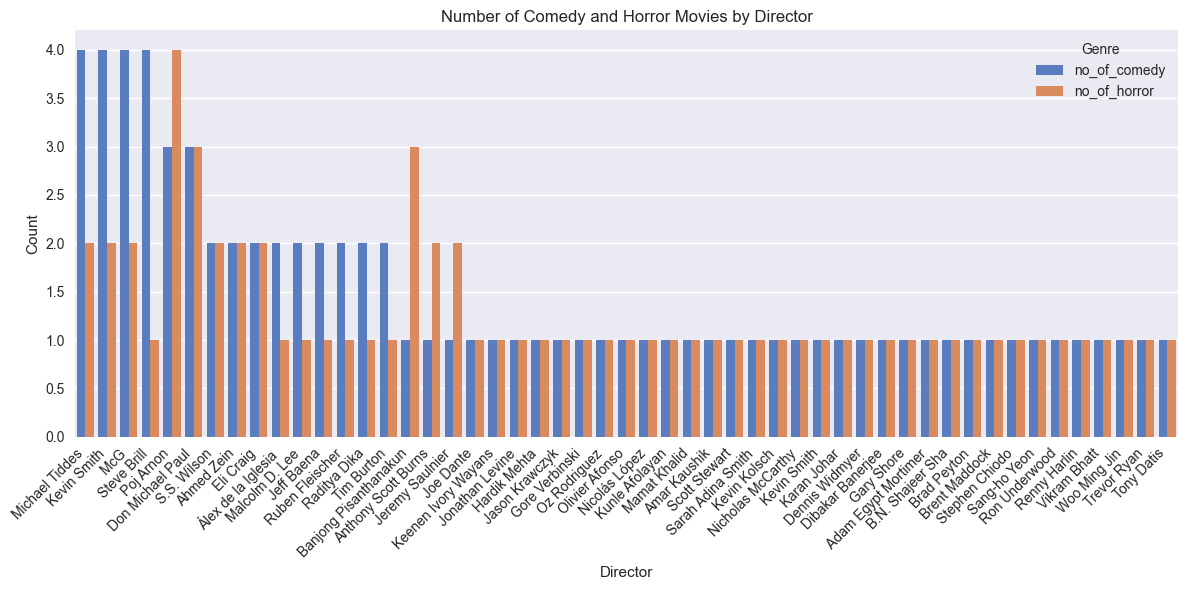

In [12]:
query5 = """
SELECT nd.director,
       COUNT(DISTINCT CASE WHEN ng.genre = 'Comedies' THEN n.show_id END) AS no_of_comedy,
       COUNT(DISTINCT CASE WHEN ng.genre = 'Horror Movies' THEN n.show_id END) AS no_of_horror
FROM netflix_stg n
INNER JOIN netflix_genre ng ON n.show_id = ng.show_id
INNER JOIN netflix_directors nd ON n.show_id = nd.show_id
WHERE type = 'Movie' AND ng.genre IN ('Horror Movies', 'Comedies')
GROUP BY nd.director
HAVING COUNT(DISTINCT ng.genre) = 2
ORDER BY no_of_comedy DESC, no_of_horror DESC
"""
df5 = run_query(query5, "Query 5")

# Visualization: Grouped bar chart for horror and comedy movies
if not df5.empty:
    df5_melted = df5.melt(id_vars='director', value_vars=['no_of_comedy', 'no_of_horror'], 
                          var_name='genre', value_name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df5_melted, x='director', y='count', hue='genre')
    plt.title('Number of Comedy and Horror Movies by Director')
    plt.xlabel('Director')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Genre')
    plt.tight_layout()
    plt.savefig('results/comedy_horror_by_director.png')
    plt.show()
    plt.close()